# Includes Channel and Batch

Coded by Lujia Zhong @lujiazho

In [1]:
!git clone https://github.com/lujiazho/MachineLearningPlayground.git

Cloning into 'MachineLearningPlayground'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 204 (delta 51), reused 117 (delta 38), pack-reused 65
Receiving objects: 100% (204/204), 25.35 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
%cd MachineLearningPlayground/

/content/MachineLearningPlayground


In [3]:
import time
import cupy as np
import pandas as pd
import matplotlib.pyplot as plt

from miniml.ann import *
from miniml.ann.common import *
from miniml.ann.utils import *

In [4]:
train = pd.read_csv('../train.csv')

train_label = train['label']
train = train.drop(['label'], axis=1)

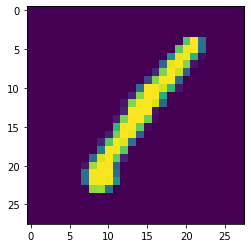

In [5]:
img = np.array(train.iloc[0]).reshape(28, 28)
_ = plt.imshow(img)

In [7]:
class Conv2D(Node):
    def __init__(self, nodes, weights, bias, output_c, input_c, stride=1, padding=False):
        self.output_c = output_c
        self.input_c = input_c
        self.stride = stride
        self.padding = padding
        self.bias = True if bias else False
        Node.__init__(self, [nodes, weights, bias] if bias else [nodes, weights])

    def conv_(self, n_c, n_h, n_w, img, filter_, s=1):
        k = filter_.shape[2]
        res = np.zeros((self.inputs[0].value.shape[0], n_c, n_h, n_w))
        aug = np.repeat(img, filter_.shape[0], axis=0)
        aug = aug.reshape(img.shape[0], filter_.shape[0], img.shape[1], img.shape[2], img.shape[3])
        for i in range(n_h):
            for j in range(n_w):
                res[:,:,i,j] = np.sum(aug[:,:,:,i*s:i*s+k,j*s:j*s+k]*filter_, axis=(2,3,4))
        return res
        
    def forward(self):
        # inputs: [batch, channel_in, hight_in, width_in]
        inputs = self.inputs[0].value
        # weights: [channel_out, channel_in, kernel_size, kernel_size]
        weights = self.inputs[1].value
        # bias: [channel_out, 1, 1] or [1, channel_out, 1, 1] is the same
        if self.bias:
            bias = self.inputs[2].value
        k = weights.shape[2]  # kernel size (w equals to h)

        s = self.stride
        if self.padding:
            inputs = np.pad(inputs, ((0,0),(0,0),(k//2,k//2),(k//2,k//2)), 'constant')
        assert (inputs.shape[2]-k)%s == 0
        assert (inputs.shape[3]-k)%s == 0
        assert s < k

        n_c = self.output_c
        new_h = (inputs.shape[2]-k)//s+1
        new_w = (inputs.shape[3]-k)//s+1

        # value: [batch, channel_out, hight_out, width_out]
        self.value = self.conv_(n_c, new_h, new_w, inputs, weights, s=s) + (bias if self.bias else 0)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        s = self.stride
        k = self.inputs[1].value.shape[2]
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_y = n.gradients[self]
            
            # calculate inserted gradient_y
            if s > 1:
                tmp = np.insert(grad_y.reshape(grad_y.shape[0],grad_y.shape[1],-1,1), 1, [[[[0]]]]*(s-1), axis=3)
                tmp = tmp.reshape(grad_y.shape[0],grad_y.shape[1],grad_y.shape[2],-1)[:,:,:,:-(s-1)]
                tmp = np.insert(tmp, np.repeat(range(1,grad_y.shape[2]), (s-1)), [0]*tmp.shape[3], axis=2)
                inser_grad = np.pad(tmp, ((0,0),(0,0),(k-1,k-1),(k-1,k-1)), 'constant')
            else:
                inser_grad = np.pad(grad_y, ((0,0),(0,0),(k-1,k-1),(k-1,k-1)), 'constant')
            
            # W: [ch_out, ch_in, kernel_size, kernel_size], rotate 2 times in h and w dimension
            rotated_w = np.rot90(self.inputs[1].value, 2, axes=(2,3))
            
            # X: [batch, ch_in, height_in, width_in]
            n_h = self.gradients[self.inputs[0]].shape[2]
            n_w = self.gradients[self.inputs[0]].shape[3]

            # A special but useful trick to calculate all together
            aug1 = np.repeat(inser_grad, rotated_w.shape[1], axis=1)
            aug1 = aug1.reshape(inser_grad.shape[0], inser_grad.shape[1], 
                                rotated_w.shape[1], inser_grad.shape[2], inser_grad.shape[3])
            aug2 = np.repeat(rotated_w, aug1.shape[1], axis=0)
            aug2 = aug2.reshape(rotated_w.shape[0], aug1.shape[1], 
                                rotated_w.shape[1], rotated_w.shape[2], rotated_w.shape[3])
            re_aug1 = np.repeat(aug1, aug2.shape[0], axis=0)
            re_aug1 = re_aug1.reshape(aug1.shape[0], aug2.shape[0], 
                                aug1.shape[1], aug1.shape[2], aug1.shape[3], aug1.shape[4])

            grad_X = np.zeros_like(X, dtype=np.float64)
            shift = k//2 if self.padding else 0
            for i in range(n_h):
                for j in range(n_w):
                    # dim 0 for batch, dim 1 and 2 for ch_out, dim 3 for ch_in, dim 4 and 5 for h&w
                    grad_X[:,:,i,j] = np.sum(re_aug1[:,:,:,:,i+shift:i+shift+k,j+shift:j+shift+k]*aug2, axis=(1,2,4,5))
            self.gradients[self.inputs[0]] += grad_X
            
            # W: [ch_out, ch_in, kernel_size, kernel_size]
            aug1 = np.repeat(inser_grad, X.shape[1], axis=1)
            aug1 = aug1.reshape(inser_grad.shape[0], inser_grad.shape[1], X.shape[1],
                                inser_grad.shape[2], inser_grad.shape[3])
            aug2 = np.repeat(X, aug1.shape[1], axis=0)
            aug2 = aug2.reshape(X.shape[0], aug1.shape[1], X.shape[1], X.shape[2], X.shape[3])
            re_aug1 = np.repeat(aug1, aug2.shape[0], axis=0)
            re_aug1 = re_aug1.reshape(aug1.shape[0], aug2.shape[0], 
                                aug1.shape[1], aug1.shape[2], aug1.shape[3], aug1.shape[4])
            
            grad_W = np.zeros_like(self.inputs[1].value, dtype=np.float64)
            
            for i in range(grad_W.shape[2]):
                for j in range(grad_W.shape[3]):
                    # dim 0 and 1 are for batch, 4 and 5 are for h and w, 2 and 3 are for ch_out and ch_in
                    grad_W[:,:,i,j] = np.sum(re_aug1[:,:,:,:,i:i+X.shape[2],j:j+X.shape[3]]*aug2, axis=(0,1,4,5))
            self.gradients[self.inputs[1]] += np.rot90(grad_W, 2, axes=(2,3))
            
            if self.bias:
                self.gradients[self.inputs[2]] += np.sum(grad_y, 
                                                         axis=(0,2,3), 
                                                         keepdims=False).reshape(grad_y.shape[1],1,1)

In [8]:
class AvePooling(Node):
    def __init__(self, nodes, k=3):
        self.k = k
        Node.__init__(self, [nodes])

    def conv_(self, n_c, n_h, n_w, img, filter_, s=1):
        k = self.k
        res = np.zeros((self.inputs[0].value.shape[0], n_c, n_h, n_w))
        for i in range(n_h):
            for j in range(n_w):
                res[:,:,i,j] = np.sum(img[:,:,i*s:i*s+k,j*s:j*s+k]*filter_, axis=(2,3))
        return res
        
    def forward(self):
        inputs = self.inputs[0].value
        k = self.k
        
        assert inputs.shape[2]%k == 0
        assert inputs.shape[3]%k == 0
        assert k > 1

        filter_ = np.ones((k, k))/(k*k)
        new_h = inputs.shape[2]//k
        new_w = inputs.shape[3]//k
        
        self.value = self.conv_(inputs.shape[1], new_h, new_w, inputs, filter_, s=k)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        s = k = self.k
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_y = n.gradients[self]

            tmp = np.insert(grad_y.reshape(grad_y.shape[0],grad_y.shape[1],-1,1), 1, [[[[0]]]]*(s-1), axis=3)
            tmp = tmp.reshape(grad_y.shape[0],grad_y.shape[1],grad_y.shape[2],-1)[:,:,:,:-(s-1)]
            tmp = np.insert(tmp, np.repeat(range(1,grad_y.shape[2]), (s-1)), [0]*tmp.shape[3], axis=2)
            inser_grad = np.pad(tmp, ((0,0),(0,0),(k-1,k-1),(k-1,k-1)), 'constant')
            
            w = np.ones((k, k))/(k*k)
            
            n_h = self.gradients[self.inputs[0]].shape[2]
            n_w = self.gradients[self.inputs[0]].shape[3]
            self.gradients[self.inputs[0]] += self.conv_(X.shape[1], n_h, n_w, inser_grad, w, s=1)

In [9]:
class Flatten(Node):
    def __init__(self, nodes):
        Node.__init__(self, [nodes])
        
    def forward(self):
        inputs = self.inputs[0].value
        self.value = inputs.flatten().reshape(inputs.shape[0],-1)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] += grad_cost.reshape(X.shape)

In [10]:
W1 = np.random.randn(3, 1, 5, 5)
b1 = np.random.randn(3, 1, 1)

W2 = np.random.randn(10, 3, 3, 3)
b2 = np.random.randn(10, 1, 1)

W3 = np.random.randn(250, 100)
b3 = np.random.randn(100)

W4 = np.random.randn(100, 10)

x_node, y_node = Placeholder(), Placeholder()

W1_node = Placeholder()
b1_node = Placeholder()

W2_node = Placeholder()
b2_node = Placeholder()

W3_node = Placeholder()
b3_node = Placeholder()

W4_node = Placeholder()

conv1 = Conv2D(x_node, W1_node, b1_node, output_c=3, input_c=1, stride=1, padding=False)
ave1 = AvePooling(conv1, k=2)
conv2 = Conv2D(ave1, W2_node, b2_node, output_c=10, input_c=3, stride=1, padding=False)
ave2 = AvePooling(conv2, k=2)
flat = Flatten(ave2)
l1 = Linear(flat, W3_node, b3_node)
tanh1 = Sigmoid(l1)
l2 = Linear(tanh1, W4_node, None)
tanh2 = Sigmoid(l2)
mse = MSE(y_node, tanh2)

In [11]:
feed_dict = {
    x_node: np.array([img]),
    y_node: np.array([0,1,0,0,0,0,0,0,0,0]),

    W1_node: W1,
    b1_node: b1,

    W2_node: W2,
    b2_node: b2,
    
    W3_node: W3,
    b3_node: b3,
    
    W4_node: W4
}

graph = feed_dict_2_graph(feed_dict)    # network graph
sorted_graph = topology(graph)          # sorted graph
trainables = [W1_node, b1_node, W2_node, b2_node, W3_node, b3_node, W4_node]

In [12]:
start_time = time.time()
optimizer = 'Adam'
lr = 1e-2
epochs = 20
batch = 2

# only used for Adam
it = 0

for i in range(1, epochs+1):
    it += 1
    losses = []
    for j in range(1, 1000, batch):
        # Step 4.1: sample a batch of examples and Reset value
        x_node.value = np.array(train.iloc[j:j+batch]).reshape(batch, 1, 28, 28)
        y_node.value = np.eye(10)[train_label[j:j+batch]].reshape(batch,-1)

        # Step 4.2: forward
        for n in sorted_graph:
            n.forward()

        # Step 4.3: backward
        for n in sorted_graph[::-1]:
            n.backward()

        # Step 4.4: optimization
        for t in trainables:
            t.optimize(optimizer=optimizer, lr=lr, it=it)

        # Step 5: update current loss
        loss = sorted_graph[-1].value
        
        losses.append(loss)

    if (i+1) % 1 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, np.mean(losses)))
print(f"{((time.time() - start_time)/epochs):.4f} sec/epoch")

Epoch: 1, Loss: 0.1100
Epoch: 2, Loss: 0.0935
Epoch: 3, Loss: 0.0899
Epoch: 4, Loss: 0.0844
Epoch: 5, Loss: 0.0820
Epoch: 6, Loss: 0.0810
Epoch: 7, Loss: 0.0788
Epoch: 8, Loss: 0.0759
Epoch: 9, Loss: 0.0713
Epoch: 10, Loss: 0.0686
Epoch: 11, Loss: 0.0666
Epoch: 12, Loss: 0.0667
Epoch: 13, Loss: 0.0663
Epoch: 14, Loss: 0.0657
Epoch: 15, Loss: 0.0652
Epoch: 16, Loss: 0.0653
Epoch: 17, Loss: 0.0653
Epoch: 18, Loss: 0.0638
Epoch: 19, Loss: 0.0636
Epoch: 20, Loss: 0.0643
18.9153 sec/epoch


In [13]:
preds = []
reals = []
for i in range(1):
    x_node.value = np.array(train.iloc[i:i+1000]).reshape(1000, 1, 28, 28)
    for n in sorted_graph[:-1]:
        n.forward()
    preds.append(np.argmax(sorted_graph[-2].value, axis=1))
    reals.append(train_label[i:i+1000])
print(np.sum(np.array(preds)==np.array(reals))/1000)

0.507


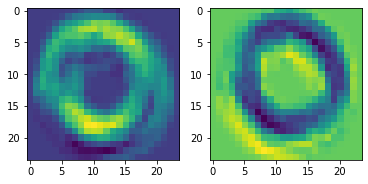

In [14]:
plt.subplot(121)
plt.imshow(conv1.value[1][0])
plt.subplot(122)
plt.imshow(conv1.value[1][1])
plt.show()

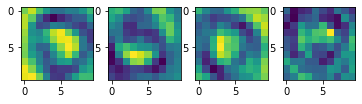

In [15]:
plt.subplot(141)
plt.imshow(conv2.value[1][0])
plt.subplot(142)
plt.imshow(conv2.value[1][1])
plt.subplot(143)
plt.imshow(conv2.value[1][2])
plt.subplot(144)
plt.imshow(conv2.value[1][3])
plt.show()